<a href="https://colab.research.google.com/github/cenzhiming/LLM-quickstart/blob/main/peft/peft_lora_whisper-large-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PEFT 库 LoRA 实战 - OpenAI Whisper-large-v2

本教程使用 LoRA 在`OpenAI Whisper-large-v2`模型上实现`语音识别(ASR)`任务的微调训练。

同时，我们还结合了`int8` 量化进一步降低训练过程资源开销，同时保证了精度几乎不受影响。

![LoRA](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/peft/lora_diagram.png)

本教程主要训练流程如下：
- 全局参数设置
- 数据准备
    - 下载数据集：训练、验证和评估集
    - 预处理数据：降采样、移除不必要字段等
    - 数据抽样（演示需要）
    - 应用数据集处理（`Dataset.map`）
    - 自定义语音数据处理器
- 模型准备
    - 加载和处理 `int8` 精度 Whisper-Large-v2 模型
    - LoRA Adapter 参数配置
    - 实例化 PEFT Model：`peft_model = get_peft_model(model, config)`
- 模型训练
    - 训练参数配置 Seq2SeqTrainingArguments
    - 实例化训练器 Seq2SeqTrainer
    - 训练模型
    - 保存模型
- 模型推理
    - 使用 `PeftModel` 加载 LoRA 微调后 Whisper 模型
    - 使用 `Pipeline API` 部署微调后 Whisper 实现中文语音识别任务

## 全局参数设置

In [ ]:
!pip install --upgrade datasets transformers accelerate

In [3]:
model_name_or_path = "openai/whisper-large-v2"
model_dir = "models/whisper-large-v2-asr-int8"

language = "Chinese (China)"
language_abbr = "zh-CN"
task = "transcribe"
dataset_name = "mozilla-foundation/common_voice_11_0"

batch_size=64

## 数据准备

### 下载数据集 Common Voice

Common Voice 11.0 数据集包含许多不同语言的录音，总时长达数小时。

本教程以中文数据为例，展示如何使用 LoRA 在 Whisper-large-v2 上进行微调训练。

首先，初始化一个DatasetDict结构，并将训练集（将训练+验证拆分为训练集）和测试集拆分好，按照中文数据集构建配置加载到内存中：

In [ ]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset(dataset_name, language_abbr, split="train", trust_remote_code=True)
common_voice["validation"] = load_dataset(dataset_name, language_abbr, split="validation", trust_remote_code=True)

common_voice["train"][1]

In [6]:
common_voice

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 29056
    })
    validation: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 10581
    })
})

## 预处理训练数据集


In [7]:
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoProcessor

# 从预训练模型加载特征提取器
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name_or_path)

# 从预训练模型加载分词器，可以指定语言和任务以获得最适合特定需求的分词器配置
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, language=language, task=task)

# 从预训练模型加载处理器，处理器通常结合了特征提取器和分词器，为特定任务提供一站式的数据预处理
processor = AutoProcessor.from_pretrained(model_name_or_path, language=language, task=task)

#### 移除数据集中不必要的字段

In [8]:
common_voice = common_voice.remove_columns(
    ["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"]
)

In [9]:
common_voice["train"][1]

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/e00e4d8d334699a4fdabff3e7abe143dfc0cb715275008fb6c3aa4f322bea389/zh-CN_train_0/common_voice_zh-CN_33211437.mp3',
  'array': array([ 1.13686838e-13, -2.78532752e-12, -4.17799129e-12, ...,
         -3.52688176e-06, -2.90906473e-06, -1.01423075e-06]),
  'sampling_rate': 48000},
 'sentence': '不包括香山公园和八大处公园内部的景点。'}

#### 降采样音频数据

查看`common_voice` 数据集介绍，你会发现其音频是以48kHz的采样率进行采样的.

而`Whisper`模型是在16kHZ的音频输入上预训练的，因此我们需要将音频输入降采样以匹配模型预训练时使用的采样率。

通过在音频列上使用`cast_column`方法，并将`sampling_rate`设置为16kHz来对音频进行降采样。

下次调用时，音频输入将实时重新取样：

In [10]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
# sampling_rate 从 48KHZ 降为 16KHZ
common_voice["train"][1]

### 整合以上数据处理为一个函数

该数据预处理函数应该包括：
- 通过加载音频列将音频输入重新采样为16kHZ。
- 使用特征提取器从音频数组计算输入特征。
- 将句子列标记化为输入标签。

In [12]:
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

### 数据抽样（演示需要）

在 Whisper-Large-v2 上使用小规模数据进行演示训练，保持以下训练参数不变（batch_size=64）。

使用 640 个样本训练，320个样本验证和评估，恰好使得1个 epoch 仅需10 steps 即可完成训练。

（在 NVIDIA T4 上需要10-15分钟）

In [13]:
small_common_voice = DatasetDict()

small_common_voice["train"] = common_voice["train"].shuffle(seed=16).select(range(640))
small_common_voice["validation"] = common_voice["validation"].shuffle(seed=16).select(range(320))

In [ ]:
small_common_voice

### 如果全量训练，则使用完整数据代替抽样

In [ ]:
# 抽样数据处理
tokenized_common_voice = small_common_voice.map(prepare_dataset)

# 完整数据训练，尝试开启 `num_proc=8` 参数多进程并行处理（如阻塞无法运行，则不使用此参数）
#tokenized_common_voice = common_voice.map(prepare_dataset, num_proc=8)
#tokenized_common_voice = common_voice.map(prepare_dataset)

In [16]:
tokenized_common_voice

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'input_features', 'labels'],
        num_rows: 640
    })
    validation: Dataset({
        features: ['audio', 'sentence', 'input_features', 'labels'],
        num_rows: 320
    })
})

### 自定义语音数据整理器

定义了一个针对语音到文本（Seq2Seq）模型的自定义数据整理器类，特别适用于输入为语音特征、输出为文本序列的数据集。


这个整理器（`DataCollatorSpeechSeq2SeqWithPadding`）旨在将数据点批量打包，将每个批次中的`attention_mask`填充到最大长度，以保持批处理中张量形状的一致性，并用`-100`替换填充值，以便在损失函数中被忽略。这对于神经网络的高效训练至关重要。

In [17]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

# 定义一个针对语音到文本任务的数据整理器类
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any  # 处理器结合了特征提取器和分词器

    # 整理器函数，将特征列表处理成一个批次
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 从特征列表中提取输入特征，并填充以使它们具有相同的形状
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # 从特征列表中提取标签特征（文本令牌），并进行填充
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 使用-100替换标签中的填充区域，-100通常用于在损失计算中忽略填充令牌
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # 如果批次中的所有序列都以句子开始令牌开头，则移除它
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        # 将处理过的标签添加到批次中
        batch["labels"] = labels

        return batch  # 返回最终的批次，准备好进行训练或评估

In [18]:
# 用给定的处理器实例化数据整理器
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

## 模型准备

### 加载预训练模型（int8 精度）

使用 `int8 ` 精度加载预训练模型，进一步降低显存需求。

In [29]:
!pip install -U bitsandbytes

In [ ]:
from transformers import AutoModelForSpeechSeq2Seq,BitsAndBytesConfig
import bitsandbytes
print(bitsandbytes.__version__)
import torch
print(f"CUDA is available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"PyTorch CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(0)}")
# !pip install git+https://github.com/huggingface/accelerate.git
# !pip install git+https://github.com/huggingface/transformers.git

quantization_config = BitsAndBytesConfig(load_in_8bit=True)

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_name_or_path,
    quantization_config=quantization_config,
    device_map="auto"
)

# model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name_or_path, load_in_8bit=True, device_map="auto")

In [20]:
# 设置模型配置中的forced_decoder_ids属性为None
model.config.forced_decoder_ids = None  # 这通常用于指定在解码（生成文本）过程中必须使用的特定token的ID，设置为None表示没有这样的强制要求

# 设置模型配置中的suppress_tokens列表为空
model.config.suppress_tokens = []  # 这用于指定在生成过程中应被抑制（不生成）的token的列表，设置为空列表表示没有要抑制的token

### PEFT 微调前的模型处理

在使用 `peft` 训练 int8 模型之前，需要进行一些预处理：
- 将所有非 `int8` 精度模块转换为全精度（`fp32`）以保证稳定性
- 为输入嵌入层添加一个 `forward_hook`，以启用输入隐藏状态的梯度计算
- 启用梯度检查点以实现更高效的内存训练

使用 `peft` 库预定义的工具函数 `prepare_model_for_int8_training`，便可自动完成以上模型处理工作。

In [22]:
# from peft import prepare_model_for_int8_training

# model = prepare_model_for_int8_training(model)
from peft import prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

### LoRA Adapter 配置

在 `peft` 中使用`LoRA`非常简捷，借助 `PeftModel`抽象，我们可以快速使用低秩适配器（LoRA）到任意模型。

通过使用 `peft` 中的 `get_peft_model` 工具函数来实现。

#### 关于 LoRA 超参数的说明：
```
MatMul(B,A) * Scaling
Scaling = LoRA_Alpha / Rank
```

In [23]:
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

# 创建一个LoraConfig对象，用于设置LoRA（Low-Rank Adaptation）的配置参数
config = LoraConfig(
    r=4,  # LoRA的秩，影响LoRA矩阵的大小
    lora_alpha=64,  # LoRA适应的比例因子
    # 指定将LoRA应用到的模型模块，通常是attention和全连接层的投影。
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,  # 在LoRA模块中使用的dropout率
    bias="none",  # 设置bias的使用方式，这里没有使用bias
)

### 使用get_peft_model函数和给定的配置来获取一个PEFT模型

In [24]:
peft_model = get_peft_model(model, config)

In [25]:
# 打印 LoRA 微调训练的模型参数
peft_model.print_trainable_parameters()

trainable params: 1,966,080 || all params: 1,545,271,040 || trainable%: 0.1272


## 模型训练

#### Seq2SeqTrainingArguments 训练参数

**关于设置训练步数和评估步数**

基于 epochs 设置：

```python
    num_train_epochs=3,  # 训练的总轮数
    evaluation_strategy="epoch",  # 设置评估策略，这里是在每个epoch结束时进行评估
    warmup_steps=50,  # 在训练初期增加学习率的步数，有助于稳定训练
```

基于 steps 设置：

```python
    max_steps=100, # 训练总步数
    evaluation_strategy="steps",
    eval_steps=25, # 评估步数
```

In [30]:
from transformers import Seq2SeqTrainingArguments

# 设置序列到序列模型训练的参数
training_args = Seq2SeqTrainingArguments(
    output_dir=model_dir,  # 指定模型输出和保存的目录
    per_device_train_batch_size=batch_size,  # 每个设备上的训练批量大小
    learning_rate=1e-3,  # 学习率
    num_train_epochs=1,  # 训练的总轮数
    eval_strategy="epoch",  # 设置评估策略，这里是在每个epoch结束时进行评估 (KEEP THIS ONE)
    # warmup_steps=50,  # 在训练初期增加学习率的步数，有助于稳定训练
    # fp16=True,  # 启用混合精度训练，可以提高训练速度，同时减少内存使用
    per_device_eval_batch_size=batch_size,  # 每个设备上的评估批量大小
    generation_max_length=128,  # 生成任务的最大长度
    logging_steps=10,  # 指定日志记录的步骤，用于跟踪训练进度
    remove_unused_columns=False,  # 是否删除不使用的列，以减少数据处理开销
    label_names=["labels"],  # 指定标签列的名称，用于训练过程中
    # eval_steps=25, # This can be uncommented if you want to set the evaluation steps
)

### 实例化 Seq2SeqTrainer 训练器

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=peft_model,
    train_dataset=tokenized_common_voice["train"],
    eval_dataset=tokenized_common_voice["validation"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
)
peft_model.config.use_cache = False

In [ ]:
trainer.train()

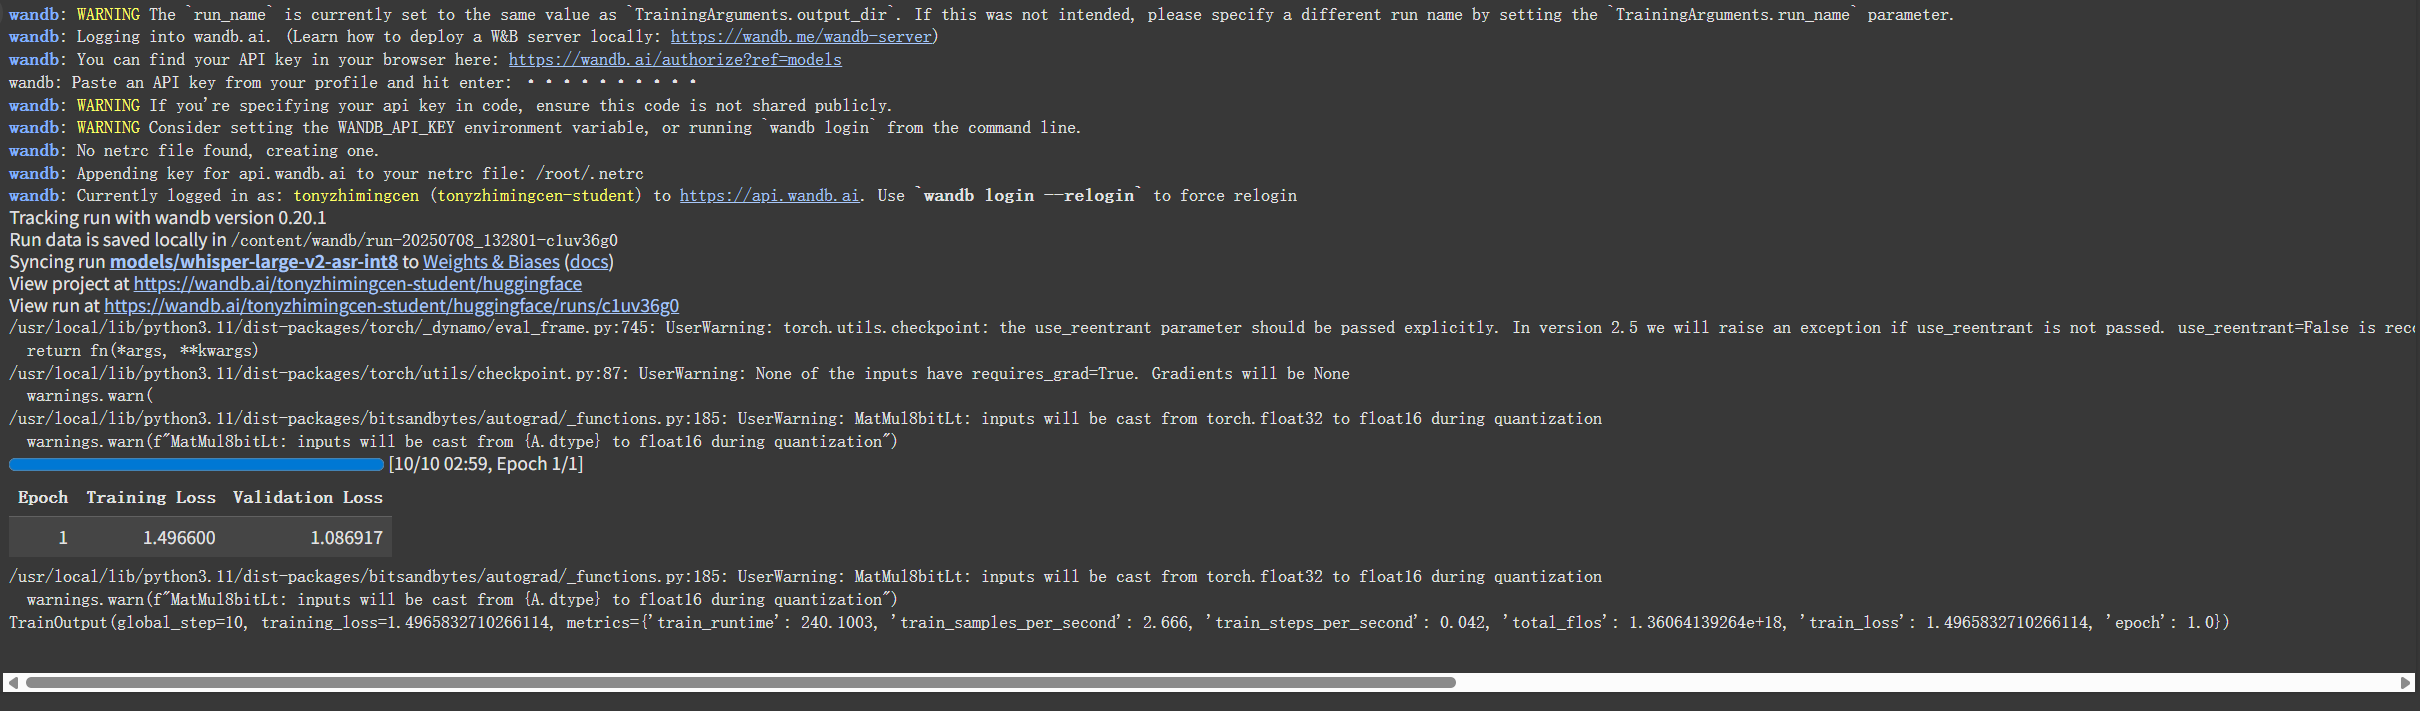

### 保存 LoRA 模型(Adapter)

In [33]:
trainer.save_model(model_dir)

In [ ]:
peft_model.eval()

## 模型推理（可能需要重启 Notebook）

**再次加载模型会额外占用显存，如果显存已经达到上限，建议重启 Notebook 后再进行以下操作**


In [ ]:
model_dir = "models/whisper-large-v2-asr-int8"

language = "Chinese (China)"
language_abbr = "zh-CN"
language_decode = "chinese"
task = "transcribe"


### 使用 `PeftModel` 加载 LoRA 微调后 Whisper 模型

使用 `PeftConfig` 加载 LoRA Adapter 配置参数，使用 `PeftModel` 加载微调后 Whisper 模型

In [ ]:
from transformers import AutoModelForSpeechSeq2Seq, AutoTokenizer, AutoProcessor
from peft import PeftConfig, PeftModel

peft_config = PeftConfig.from_pretrained(model_dir)

base_model = AutoModelForSpeechSeq2Seq.from_pretrained(
    peft_config.base_model_name_or_path, load_in_8bit=True, device_map="auto"
)

peft_model = PeftModel.from_pretrained(base_model, model_dir)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
processor = AutoProcessor.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
feature_extractor = processor.feature_extractor

### 使用 Pipeline API 部署微调后 Whisper 实现中文语音识别任务

In [ ]:
test_audio = "data/audio/test_zh.flac"

In [ ]:
from transformers import AutomaticSpeechRecognitionPipeline

pipeline = AutomaticSpeechRecognitionPipeline(model=peft_model, tokenizer=tokenizer, feature_extractor=feature_extractor)

forced_decoder_ids = processor.get_decoder_prompt_ids(language=language_decode, task=task)

In [ ]:
import torch

with torch.cuda.amp.autocast():
    text = pipeline(test_audio, max_new_tokens=255)["text"]

/root/miniconda3/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [ ]:
text

'这是一段测试用于WhisperLarge V2模型的自动语音识别测试。'

## Homework

1. 使用完整的数据集训练，对比 Train Loss 和 Validation Loss 变化。训练完成后，使用测试集进行模型评估.
2. [Optional]使用其他语种（如：德语、法语等）的数据集进行微调训练，并进行模型评估模型评估。